In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
x_train = x_train / 255.0
x_test = x_test / 255.0

In [4]:
x_train = x_train.reshape(-1, 28 * 28)
x_test = x_test.reshape(-1, 28 * 28)

In [5]:
y_train_even_odd = np.array([label % 2 for label in y_train])
y_test_even_odd = np.array([label % 2 for label in y_test])

In [6]:
model = tf.keras.Sequential([tf.keras.layers.Dense(1, activation='sigmoid', input_shape=(28 * 28,))])

/Users/parthabhang/Desktop/DL/quantiota/quantiotaenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
model.fit(x_train, y_train_even_odd, epochs=5, batch_size=32)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 382us/step - accuracy: 0.8380 - loss: 0.3794
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 378us/step - accuracy: 0.8919 - loss: 0.2747
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 404us/step - accuracy: 0.8966 - loss: 0.2613
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 390us/step - accuracy: 0.8966 - loss: 0.2625
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 381us/step - accuracy: 0.8981 - loss: 0.2591


In [9]:
loss, accuracy = model.evaluate(x_test, y_test_even_odd)
print(f'Original Test Accuracy: {accuracy:.4f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - accuracy: 0.8910 - loss: 0.2704
Original Test Accuracy: 0.8975


In [10]:
learning_rate = 0.005 
delta = 0.1
epochs = 5
batch_size = 32
input_size = 28 * 28

In [11]:
w1 = np.random.randn(input_size) * 0.01
G1 = np.random.randn(input_size) * 0.01
b1 = 0.01

In [12]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [13]:
def entropy_gradient(z, D):
    return - (1 / np.log(2)) * z * D * (1 - D)

In [14]:
def forward_pass(x):
    z = np.dot(x, (w1 + G1)) + b1
    D = sigmoid(z)
    return z, D

In [ ]:
accuracy_history = []
for epoch in range(epochs):
    for i in range(0, len(x_train), batch_size):
        x_batch = x_train[i:i + batch_size]
        y_batch = y_train_even_odd[i:i + batch_size]

        
        z, D = forward_pass(x_batch)
        gradient = entropy_gradient(z, D)

        # Parameter updates
        w1_update = -learning_rate * np.dot(x_batch.T, gradient)
        G1_update = -learning_rate * np.dot(x_batch.T, gradient)
        b1_update = -learning_rate * np.sum(gradient)

        
        z_change = np.abs(w1_update + G1_update)
        scale_factor = np.minimum(1.0, delta / np.max(z_change))
        w1 += scale_factor * w1_update
        G1 += scale_factor * G1_update
        b1 += scale_factor * b1_update

    
    z_test, D_test = forward_pass(x_test)
    predictions = (D_test >= 0.5).astype(int)
    accuracy = np.mean(predictions == y_test_even_odd)
    accuracy_history.append(accuracy)
    print(f"Epoch {epoch + 1}/{epochs}, Test Accuracy: {accuracy:.4f}")

Epoch 1/5, Test Accuracy: 0.5074
Epoch 2/5, Test Accuracy: 0.5074
Epoch 3/5, Test Accuracy: 0.5074
Epoch 4/5, Test Accuracy: 0.5074
Epoch 5/5, Test Accuracy: 0.5074


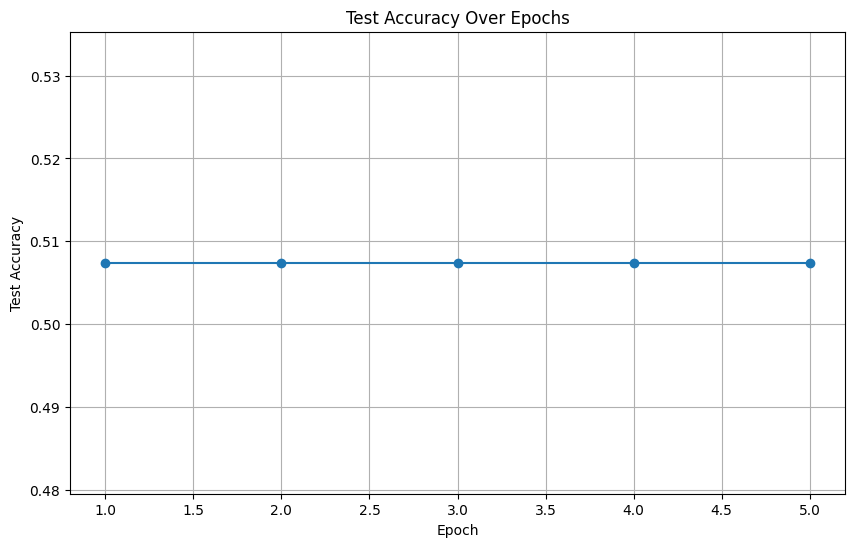

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), accuracy_history, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Over Epochs')
plt.grid()
plt.show()

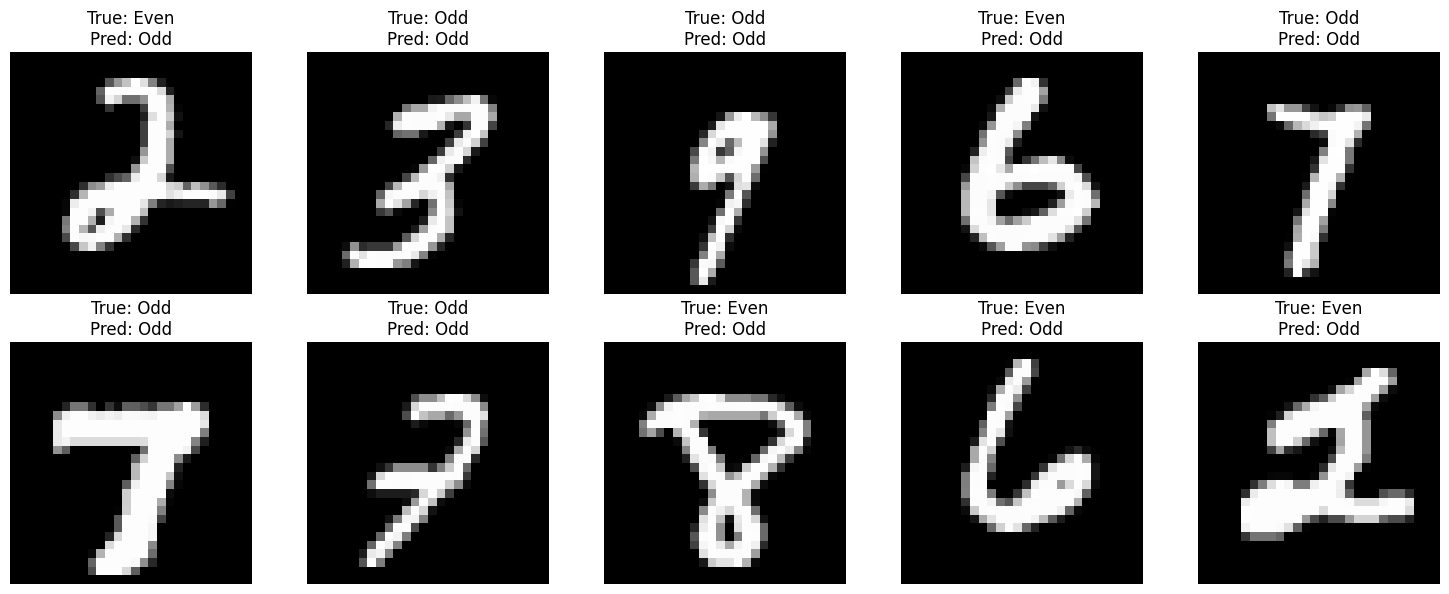


Key Changes Implemented:
1. Dual-weight structure (w1 and G1).
2. Entropy-gradient based updates.
3. z mapping constraint (|z_i+1 - z_i| < delta).
4. Custom training loop replacing built-in optimizer.


In [17]:
random_indices = np.random.choice(len(x_test), 10, replace=False)
plt.figure(figsize=(15, 6))

for idx, i in enumerate(random_indices):
    image = x_test[i].reshape(28, 28)
    true_label = y_test_even_odd[i]
    pred_label = predictions[i]
    true_text = "Odd" if true_label == 1 else "Even"
    pred_text = "Odd" if pred_label == 1 else "Even"

    plt.subplot(2, 5, idx + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"True: {true_text}\nPred: {pred_text}")
    plt.axis('off')

plt.tight_layout()
plt.show()

print("\nKey Changes Implemented:")
print("1. Dual-weight structure (w1 and G1).")
print("2. Entropy-gradient based updates.")
print("3. z mapping constraint (|z_i+1 - z_i| < delta).")
print("4. Custom training loop replacing built-in optimizer.")
